# Experiments with rescaling images using SIREN activation function

## Author: Mathias Are

## Models reconfigured for colored images by Stephane Boire

### Used Vincent Sitzmann's explore_siren notebook from SIREN github repository: https://github.com/vsitzmann/siren




In [2]:


# NB! Only for Colab
#Imports files


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time


In [4]:
#Methods from SIREN github repo


def get_mgrid(sidelen, dim=2, depth=1):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])+(torch.linspace(-1, 1, steps=depth),)
    print(tensors[0].size(), tensors[1].size(), tensors[2].size())
    print(len(torch.meshgrid(*tensors)))
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    print("Mgrid step 2: ", mgrid.size())
    mgrid = mgrid.reshape(depth, sidelen**2, dim+1)
    print("Mgrid step 3: ", mgrid.size())
    return mgrid


def lin2img(tensor, image_resolution=None):
    batch_size, num_samples, channels = (512,512,3)
    if image_resolution is None:
        width = np.sqrt(num_samples).astype(int)
        height = width
    else:
        height = image_resolution[0]
        width = image_resolution[1]

    return tensor.permute(0, 2, 1).view(batch_size, channels, height, width)


def rescale_img(x, mode='scale', perc=None, tmax=1.0, tmin=0.0):
    if (mode == 'scale'):
        if perc is None:
            xmax = torch.max(x)
            xmin = torch.min(x)
        else:
            xmin = np.percentile(x.detach().cuda().numpy(), perc)
            xmax = np.percentile(x.detach().cuda().numpy(), 100 - perc)
            x = torch.clamp(x, xmin, xmax)
        if xmin == xmax:
            return 0.5 * torch.ones_like(x) * (tmax - tmin) + tmin
        x = ((x - xmin) / (xmax - xmin)) * (tmax - tmin) + tmin
    elif (mode == 'clamp'):
        x = torch.clamp(x, 0, 1)
    return x

In [5]:

#Sinelayer class to build neural network layers, reconfigured for colored images


class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    

    #Neural networok with SIREN activation function as layers

    
class Siren(nn.Module):


    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        #output=gradient(output, coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [6]:
#Methods for getting laplace and gradient for each pixel value

def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

In [7]:
#Image importing and transfromation to correct size

def get_image(img,sidelength=128):
    imgA = Image.fromarray(np.array(img))
    transform = Compose([
        Resize((sidelength, sidelength)),
        ToTensor()
        #Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    imgA = transform(imgA)
    imgA=imgA.permute(1, 2, 0)
    return imgA

In [8]:
#Object for image fitting

class ImageFitting(Dataset):
    def __init__(self, sidelength, img_input, nb_images=1):
        super().__init__()
        img = img_input.reshape(sidelength**2, 3)
        print("Pixels size: ", img.size())
        self.pixels = img
        self.coords = get_mgrid(sidelength, 2, depth=nb_images)
        print("Coords size: ", self.coords.size())

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > len(self.pixels): raise IndexError
            
        return self.coords, self.pixels

In [17]:
#Importing and fitting Images

case1 = Image.open("/content/drive/MyDrive/data/case2.jpg")
case2 = Image.open("/content/drive/MyDrive/data/case1.jpg")


cat1 = get_image(case1,128)
cat2=get_image(case2,128)

train_pic = ImageFitting(128,cat1,nb_images=1)
test_pic = ImageFitting(128,cat2,nb_images=1)


#Creating dataloaders
dlTrain = DataLoader(train_pic, batch_size=1, pin_memory=True, num_workers=0)
dlTest=DataLoader(test_pic, batch_size=1, pin_memory=True, num_workers=0)

#Initiating the network

img_siren = Siren(in_features=3, out_features=3, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()

Pixels size:  torch.Size([16384, 3])
torch.Size([128]) torch.Size([128]) torch.Size([1])
3
Mgrid step 2:  torch.Size([128, 128, 1, 3])
Mgrid step 3:  torch.Size([1, 16384, 3])
Coords size:  torch.Size([1, 16384, 3])
Pixels size:  torch.Size([16384, 3])
torch.Size([128]) torch.Size([128]) torch.Size([1])
3
Mgrid step 2:  torch.Size([128, 128, 1, 3])
Mgrid step 3:  torch.Size([1, 16384, 3])
Coords size:  torch.Size([1, 16384, 3])


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=3, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [18]:
total_steps = 1000#nr of steps
steps_til_summary = 100   #nr of steps until picture shown
losses={
    'first':[],
    'second':[]
}
#Size of the predicted image
size_img=128
optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input, na = next(iter(dlTrain))
nan,ground_truth=next(iter(dlTest))
ground_truth=ground_truth.resize(1, 1, size_img**2, 3)
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
print("Input, output sizes; ", model_input.size(), ground_truth.size())
print("Model_input: ", model_input[:3, :3])


for step in range(total_steps):
    
    model_output, coords = img_siren(model_input)
    
    loss = ((model_output - ground_truth)**2).mean()
    losses["first"].append(loss)
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        img_grad_1 = gradient(model_output, coords)
        img_laplacian = laplace(model_output, coords)

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        #print("Size image: ", model_output.cpu()[:1, :16384, :].size())
        axes[0].imshow(model_output.cpu()[:, :1, :].view(size_img,size_img, 3).detach().numpy())
        axes[1].imshow(img_grad_1.norm(dim=-1).cpu()[:, :1].view(size_img,size_img).detach().numpy())
        axes[2].imshow(img_laplacian.cpu()[:, :1].view(size_img,size_img).detach().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

Output hidden; open in https://colab.research.google.com to view.

In [19]:
#Importing and fitting Images

case1 = Image.open("/content/drive/MyDrive/data/white.jpg")
case2 = Image.open("/content/drive/MyDrive/data/case1.jpg")


cat1 = get_image(case1,128)
cat2=get_image(case2,128)

train_pic = ImageFitting(128,cat1,nb_images=1)
test_pic = ImageFitting(128,cat2,nb_images=1)


#Creating dataloaders
dlTrain = DataLoader(train_pic, batch_size=1, pin_memory=True, num_workers=0)
dlTest=DataLoader(test_pic, batch_size=1, pin_memory=True, num_workers=0)

#Initiating the network

img_siren = Siren(in_features=3, out_features=3, hidden_features=128, 
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()

Pixels size:  torch.Size([16384, 3])
torch.Size([128]) torch.Size([128]) torch.Size([1])
3
Mgrid step 2:  torch.Size([128, 128, 1, 3])
Mgrid step 3:  torch.Size([1, 16384, 3])
Coords size:  torch.Size([1, 16384, 3])
Pixels size:  torch.Size([16384, 3])
torch.Size([128]) torch.Size([128]) torch.Size([1])
3
Mgrid step 2:  torch.Size([128, 128, 1, 3])
Mgrid step 3:  torch.Size([1, 16384, 3])
Coords size:  torch.Size([1, 16384, 3])


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=3, out_features=128, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=128, out_features=128, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=128, out_features=128, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=128, out_features=128, bias=True)
    )
    (4): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [20]:
total_steps = 1000#nr of steps
steps_til_summary = 100   #nr of steps until picture shown

#Size of the predicted image
size_img=128
optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input, na = next(iter(dlTrain))
nan,ground_truth=next(iter(dlTest))
ground_truth=ground_truth.resize(1, 1, size_img**2, 3)
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
print("Input, output sizes; ", model_input.size(), ground_truth.size())
print("Model_input: ", model_input[:3, :3])


for step in range(total_steps):
    
    model_output, coords = img_siren(model_input)
    
    loss = ((model_output - ground_truth)**2).mean()
    losses["second"].append(loss)
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        img_grad_1 = gradient(model_output, coords)
        img_laplacian = laplace(model_output, coords)

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        #print("Size image: ", model_output.cpu()[:1, :16384, :].size())
        axes[0].imshow(model_output.cpu()[:, :1, :].view(size_img,size_img, 3).detach().numpy())
        axes[1].imshow(img_grad_1.norm(dim=-1).cpu()[:, :1].view(size_img,size_img).detach().numpy())
        axes[2].imshow(img_laplacian.cpu()[:, :1].view(size_img,size_img).detach().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

Output hidden; open in https://colab.research.google.com to view.

In [21]:
import pandas as pd


df = pd.DataFrame.from_dict(losses)

In [22]:
losses["first"][0]
df['first'] = df['first'].astype(float)
df['second'] = df['second'].astype(float)

In [23]:
x = []

for j in range(0,1000,100):
  x.append(j)

x

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900]

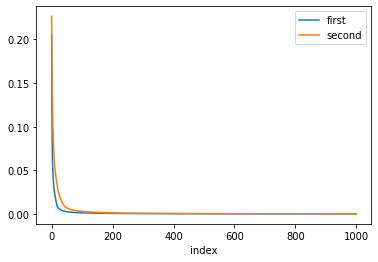

In [24]:
df.reset_index().plot(x='index')